On commence par importer les librairies nécessaires

In [61]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pulp as pl
import random

#### 1. Partie Commune


1) Génerer les noeuds et l'ensemble des arcs aléatoirement

In [62]:
random.seed(2200299)
N= np.random.randint(20, 50)
A= np.random.randint(50, 100)

Générer un graphe aléatoire orienté

In [63]:
G=nx.gnm_random_graph(N,A,seed=2200299,directed=True)

Identifier les boucles et les supprimer

In [64]:
boucles=list(nx.selfloop_edges(G))
G.remove_edges_from(boucles)

Afficher le graphe

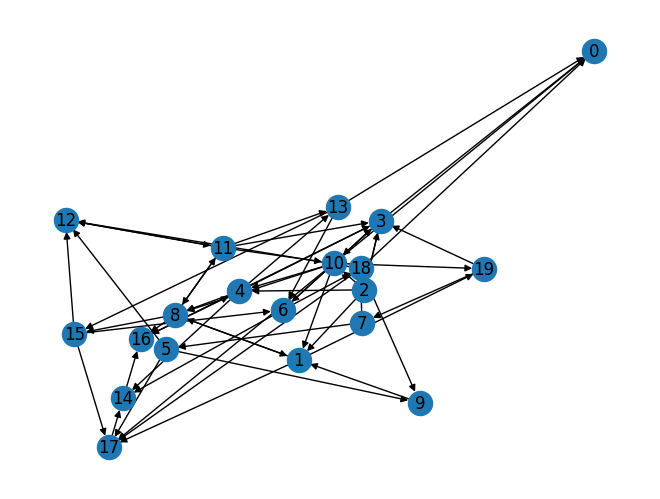

In [65]:
nx.draw_spring(G,with_labels=True)
plt.show()

Vérifier si le nombre de noeuds et le nombre d'arcs générés sont corrects.

In [66]:
print("Le nombre de noeuds initialisé est égal à ", N, "et le nombre de noeuds du graphe est égal à ", G.number_of_nodes())
print("Le nombre d'arcs initialisé est égal à ", A, "et le nombre d'arcs du graphe est égal à ", G.number_of_edges())

Le nombre de noeuds initialisé est égal à  20 et le nombre de noeuds du graphe est égal à  20
Le nombre d'arcs initialisé est égal à  57 et le nombre d'arcs du graphe est égal à  57


2) Définir U et C et affecter les coûts et les capacités aléatoirement sur les arcs dans les intervalles [0,C] et [0,U] respectivement

In [67]:
U,C=20,50
for i, j in G.edges():
    G[i][j]['u'] = np.random.randint(0, U)
    G[i][j]['c'] = np.random.randint(0, C)

# Print the capacities and costs of each edge
for i, j in G.edges():
    print(f"({i}, {j}): U = {G[i][j]['u']}, C = {G[i][j]['c']}")

(1, 8): U = 5, C = 27
(1, 19): U = 5, C = 0
(1, 17): U = 0, C = 33
(2, 3): U = 4, C = 45
(2, 10): U = 18, C = 38
(2, 1): U = 10, C = 31
(2, 4): U = 14, C = 39
(3, 6): U = 10, C = 33
(3, 2): U = 8, C = 15
(3, 10): U = 10, C = 22
(3, 0): U = 1, C = 24
(3, 16): U = 2, C = 36
(4, 13): U = 1, C = 24
(4, 14): U = 5, C = 39
(4, 3): U = 5, C = 4
(4, 8): U = 13, C = 5
(5, 12): U = 18, C = 39
(5, 9): U = 6, C = 0
(5, 17): U = 5, C = 48
(6, 18): U = 0, C = 24
(6, 14): U = 2, C = 13
(6, 3): U = 14, C = 32
(7, 5): U = 2, C = 15
(7, 18): U = 5, C = 47
(8, 1): U = 18, C = 17
(8, 16): U = 17, C = 12
(8, 15): U = 19, C = 36
(8, 11): U = 2, C = 47
(9, 1): U = 19, C = 42
(10, 8): U = 10, C = 7
(10, 19): U = 14, C = 5
(10, 17): U = 7, C = 17
(10, 4): U = 11, C = 42
(10, 1): U = 15, C = 16
(10, 0): U = 3, C = 17
(11, 13): U = 4, C = 28
(11, 8): U = 10, C = 15
(11, 10): U = 19, C = 35
(11, 12): U = 19, C = 25
(11, 3): U = 5, C = 26
(12, 11): U = 18, C = 41
(13, 15): U = 0, C = 11
(13, 6): U = 10, C = 49
(13

#### 3. Problème de flot à coût minimum avec capacité


1. Définir un ensemble de sources S ⊆ N et un ensemble de destinations T ⊆ N

In [68]:
S = set(np.random.choice(list(G.nodes()), size=5, replace=False))
T = set(np.random.choice(list(G.nodes()), size=8, replace=False))
while not S.isdisjoint(T):
    T = set(np.random.choice(list(G.nodes()), size=8, replace=False))

Vérifier qu'ils sont disjoints

In [69]:
while len(S.intersection(T)) > 0:
    T = set(np.random.sample(8))

Afficher S et T

In [70]:
print("Sources:", S)
print("Destinations:", T)

Sources: {0, 2, 9, 17, 19}
Destinations: {1, 4, 5, 7, 12, 15, 16, 18}


2. Affecter des valeurs d’offre de trafic sur les noeuds sources dans l’intervalle $[0,\overline{\rm ds}]$


In [71]:
ds_bar = 20
for i in S:
        G.nodes[i]['traffic_offer'] = np.random.uniform(0, ds_bar)

3. Affecter des valeurs de demande de trafic sur les noeuds destinations dans l’intervalle $[0,\overline{\rm dt}]$

In [72]:
dt_bar = 20
for i in T:
    G.nodes[i]['traffic_demand'] = np.random.uniform(0, dt_bar)

4. Résolution du problème d'optimisation

In [73]:
# Création du problème linéaire en utilisant la méthode LpProblem de la librairie pulp
prob = pl.LpProblem("Probleme_de_flot_a_cout_minimum", pl.LpMinimize)

# Création des variables de décision
variables = pl.LpVariable.dicts("Flux", ((i, j) for (i, j) in G.edges()), lowBound=0, cat='Continuous')

# Ajout de la fonction objectif
prob += pl.lpSum([G[i][j]['c'] * variables[(i, j)] for (i, j) in G.edges()]), "Cout_Total_du_Flux"

# Ajout de la contrainte de conservation de flux pour chaque nœud
for node in G.nodes():
    if node not in S.union(T):
        prob += pl.lpSum([variables[(i, j)] for (i, j) in G.in_edges(node)]) \
                == pl.lpSum([variables[(i, j)] for (i, j) in G.out_edges(node)]), f"Conservation_Flux_{node}"

# Ajout des contraintes de capacité pour chaque arc
for (i, j) in G.edges():
    prob += variables[(i, j)] <= G[i][j]['u'], f"Capacite_{(i, j)}"

# Ajout de la contrainte de demande à satisfaire pour chaque nœud destination
for node in T:
    prob += pl.lpSum([variables[(i, j)] for (i, j) in G.out_edges(node)]) \
            == G.nodes[node]['traffic_demand'], f"Demande_{node}"

# Ajout de la contrainte d'offre pour chaque nœud source
for node in S:
    prob += pl.lpSum([variables[(i, j)] for (i, j) in G.out_edges(node)]) \
            == G.nodes[node]['traffic_offer'], f"Offre_{node}"

# Résolution du problème d'optimisation
prob.solve()

# Affichage de la solution optimale
print(f"Le coût total minimal du flux est de {pl.value(prob.objective)}")

# Affichage des variables de base optimales
for (i, j) in G.edges():
    if variables[(i, j)].varValue > 0:
        print(f"Flux de ({i}, {j}) = {variables[(i, j)].varValue}")


Le coût total minimal du flux est de 1731.4073061000001
Flux de (1, 19) = 10.15244
Flux de (2, 1) = 10.066161
Flux de (7, 5) = 10.720338
Flux de (11, 8) = 13.015637
Flux de (12, 11) = 13.015637
Flux de (18, 17) = 12.768317
Flux de (19, 3) = 8.3891779


Vérification si la situation est optimale

In [74]:
# Résolution du problème d'optimisation
prob.solve()
# Vérification si la solution est optimale
if prob.status == pl.LpStatusOptimal:
    print("Solution optimale trouvée")
    print("Valeur de la fonction objectif:", pl.value(prob.objective))
    print("Variables de base optimales:")
    for var in prob.variables():
        if var.varValue > 0:
            print(var.name, "=", var.varValue)
else:
    print("La solution n'est pas optimale")


La solution n'est pas optimale


Résolution de solution optimale

Statut: Infeasible
la solution optimal est : 99.0
Flot de 2 vers 6: 4.0
Flot de 4 vers 8: 1.0
Flot de 4 vers 9: 3.0
Flot de 5 vers 9: 3.0
Flot de 6 vers 11: 4.0
Flot de 6 vers 12: 2.0
Flot de 8 vers 12: 1.0
Flot de 9 vers 13: 5.0


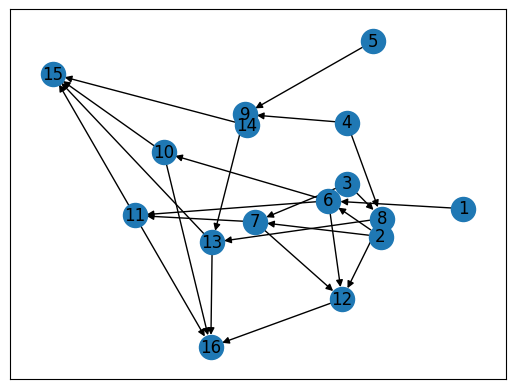

In [75]:
import numpy as np
import networkx as nx
import pulp

# Définition du graphe
G = nx.DiGraph()

# Ajout des nœuds
G.add_nodes_from(range(1, 17))

# Définition des sources et des destinations
S = {1, 2, 3, 4, 5}
T = {9, 10, 11, 12, 13, 14, 15, 16}

# Affectation des offres et des demandes
offres = np.random.randint(1, 5, len(S))
demandes = np.random.randint(1, 5, len(T))
while offres.sum() != demandes.sum():
    if offres.sum() > demandes.sum():
        offres[np.random.randint(0, len(S))] -= 1
    else:
        demandes[np.random.randint(0, len(T))] -= 1

# Ajout des arcs avec leur capacité et leur coût
for i, j, c, w in [
    (1, 6, 3, 6),
    (2, 6, 2, 7),
    (2, 7, 2, 8),
    (3, 7, 1, 5),
    (3, 8, 4, 4),
    (4, 8, 1, 4),
    (4, 9, 2, 9),
    (5, 9, 3, 3),
    (6, 10, 1, 3),
    (6, 11, 3, 2),
    (6, 12, 2, 1),
    (7, 11, 2, 5),
    (7, 12, 2, 2),
    (8, 12, 2, 1),
    (8, 13, 3, 3),
    (9, 13, 2, 4),
    (9, 14, 1, 6),
    (10, 15, 2, 7),
    (10, 16, 2, 2),
    (11, 15, 1, 5),
    (11, 16, 3, 6),
    (12, 16, 2, 7),
    (13, 15, 1, 2),
    (13, 16, 2, 9),
    (14, 15, 3, 3)
]:
    G.add_edge(i, j, capacity=c, weight=w)

# Définition du problème d'optimisation
prob = pulp.LpProblem("Flot à coût minimum avec capacité", pulp.LpMinimize)

# Variables de décision
flot = {(i, j): pulp.LpVariable(f"f_{i}_{j}", lowBound=0) for i, j in G.edges()}

# Fonction objectif
prob += pulp.lpSum(flot[i, j] * G[i][j]['weight'] for i, j in G.edges())

# Contraintes de capacité
for i, j in G.edges():
    prob += (flot[i, j] <= G[i][j]['capacity'])

# Conservation de flux
for n in G.nodes():
    if n in S:
        prob += (pulp.lpSum(flot[i, j] for i, j in G.out_edges(n)) -
                 pulp.lpSum(flot[i, j] for i, j in G.in_edges(n)) == offres[list(S).index(n)])
    elif n in T:
        prob += (pulp.lpSum(flot[i, j] for i, j in G.out_edges(n)) -
                 pulp.lpSum(flot[i, j] for i, j in G.in_edges(n)) == -demandes[list(T).index(n)])
    else:
        prob += (pulp.lpSum(flot[i, j] for i, j in G.out_edges(n)) -
                 pulp.lpSum(flot[i, j] for i, j in G.in_edges(n)) == 0)


for i in S:
    prob += (pulp.lpSum(flot[i, j] for i, j in G.out_edges(i)) ==
    offres[list(S).index(i)])
for j in T:
    prob += (pulp.lpSum(flot[i, j] for i, j in G.in_edges(j)) ==
    demandes[list(T).index(j)])


prob.solve()

print("Statut:", pulp.LpStatus[prob.status])
print("la solution optimal est :", pulp.value(prob.objective))
for i, j in G.edges():
    if pulp.value(flot[i, j]) > 0:
        print(f"Flot de {i} vers {j}: {pulp.value(flot[i, j])}")
nx.draw_networkx(G)